# Method 1: Semantic Vector Search

In [10]:
import numpy as np
import pandas as pd
import json
import google.generativeai as genai
import os
from tqdm.notebook import tqdm
import faiss
from pinecone import Pinecone, ServerlessSpec
import time

## Data Preprocessing

In [2]:
df = pd.read_csv('../../datasets/tmdb_5000_movies.csv',)
df = df[['id','title','overview','genres','popularity','release_date','runtime']]

df['release_date'] = pd.to_datetime(df['release_date'])

def extract_genres(genre_json):
    # Parse the JSON string into a list
    genres = json.loads(genre_json)
    # Extract the 'name' field and join with a comma
    return ', '.join(genre['name'] for genre in genres)

df['genres'] = df['genres'].apply(extract_genres)

df.head()

,id,title,overview,genres,popularity,release_date,runtime
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","Action, Adventure, Fantasy, Science Fiction",150.437577,2009-12-10,162.0
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","Adventure, Fantasy, Action",139.082615,2007-05-19,169.0
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"Action, Adventure, Crime",107.376788,2015-10-26,148.0
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"Action, Crime, Drama, Thriller",112.312950,2012-07-16,165.0
4,49529,John Carter,"John Carter is a war-weary, former military ca...","Action, Adventure, Science Fiction",43.926995,2012-03-07,132.0


In [3]:
df = df.sort_values(by='popularity', ascending=False).head(150)
df.sample(10)

,id,title,overview,genres,popularity,release_date,runtime
262,120,The Lord of the Rings: The Fellowship of the Ring,"Young hobbit Frodo Baggins, after inheriting a...","Adventure, Fantasy, Action",138.049577,2001-12-18,178.0
634,603,The Matrix,"Set in the 22nd century, The Matrix tells the ...","Action, Science Fiction",104.309993,1999-03-30,136.0
197,671,Harry Potter and the Philosopher's Stone,Harry Potter has lived under the stairs at his...,"Adventure, Fantasy, Family",109.984351,2001-11-16,152.0
1881,278,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,"Drama, Crime",136.747729,1994-09-23,142.0
1465,198663,The Maze Runner,"Set in a post-apocalyptic world, young Thomas ...","Action, Mystery, Science Fiction, Thriller",131.815575,2014-09-10,113.0
514,950,Ice Age: The Meltdown,"Diego, Manny and Sid return in this sequel to ...","Animation, Family, Comedy, Adventure",85.115058,2006-03-23,91.0
662,550,Fight Club,A ticking-time-bomb insomniac and a slippery s...,Drama,146.757391,1999-10-15,139.0
506,93456,Despicable Me 2,Gru is recruited by the Anti-Villain League to...,"Animation, Comedy, Family",136.886704,2013-06-25,98.0
17,1865,Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,"Adventure, Action, Fantasy",135.413856,2011-05-14,136.0
2731,240,The Godfather: Part II,In the continuing saga of the Corleone crime f...,"Drama, Crime",105.792936,1974-12-20,200.0


In [4]:
df.isnull().sum()

id              0
title           0
overview        0
genres          0
popularity      0
release_date    0
runtime         0
dtype: int64

In [5]:
df.dtypes

id                       int64
title                   object
overview                object
genres                  object
popularity             float64
release_date    datetime64[ns]
runtime                float64
dtype: object

## Gemini Embedding Model

In [6]:
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001
models/text-embedding-004


In [7]:
def embed_fn(title, text, model='models/text-embedding-004'):
  return genai.embed_content(model=model,
                             title = title,
                             content=text,
                             task_type="retrieval_document")["embedding"]

def embed_fn2(text, model='models/text-embedding-004'):
  return genai.embed_content(model=model,
                             content=text,
                             task_type="retrieval_query")["embedding"]


In [8]:
test_emb = embed_fn2("Somewhere, you'll grow up and u'll be the savior of the broken, the beaten and the damned.")
print(len(test_emb), test_emb[:5])

768 [-0.013676994, 0.007881582, -0.045579694, 0.05037779, -0.02828522]


In [9]:
tqdm.pandas()
df['Embeddings'] = df.progress_apply(lambda row: embed_fn(row['title'], row['overview']), axis=1)

  0%|          | 0/150 [00:00<?, ?it/s]

## Pinecone Vector DB

In [19]:
pc = Pinecone(api_key=os.getenv('PINECONE_API_KEY'))

In [34]:
index_name = "test-index"

def get_or_create_index(index_name):
    index_exists = any(index['name'] == index_name for index in pc.list_indexes().indexes)
    
    if not index_exists:
        pc.create_index(
            name=index_name,
            dimension=768, # 1536
            metric="cosine",
            spec=ServerlessSpec(
                cloud="aws",
                region="us-east-1"
            ) 
        )
        print(f"Index '{index_name}' created")
    return pc.Index(index_name)

# pc.delete_index(INDEX_NAME)

In [85]:
def indexing_pipeline():
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)
    
    index = get_or_create_index(index_name)
    print('Indexing Started..')
    for _, row in df.iterrows():
        index.upsert([(str(row['id']),
                       row['Embeddings'],
                       {'title': row['title'],
                        'runtime': row['runtime'],
                        'genres': row['genres'],
                        'year': row['release_date'].year
                       }
                      )])
    print('Finished Indexing')

### Gradio Applications

In [ ]:
import gradio as gr

def search(query):
    index = get_or_create_index(index_name)
    vector = embed_fn2(query)
    res = index.query(
        vector=vector,
        top_k=5,
        include_metadata=True # Include metadata in the response.
    )
    return pd.DataFrame([{
        'id': doc['id'],
        'title': doc['metadata']['title'],
        'year': doc['metadata']['year'],
        'score': doc['score']
    } for doc in res['matches']])



demo = gr.Interface(
    fn=search,
    inputs = gr.Textbox(label="Search for a movie"),
    outputs = gr.Dataframe(),
    title="Movie Recommendation System",
    description="Enter query and get the most semantically similar movie recommendations"
)

demo.launch()

In [ ]:
import gradio as gr
import numpy as np

choices = ['Spider-Man', 'Up', 'Spirited Away',
               'The Dark Knight', 'Fight Club', 'Inception',
               'Harry Potter and the Chamber of Secrets', 'The Devil Wears Prada' ]

def search2(emb, ids):
    index = get_or_create_index(index_name)
    res = index.query(
        vector=emb,
        top_k=5,
        filter = {
            "id": {"$nin": ids }
        },
        include_metadata=True # Include metadata in the response.
    )
    return pd.DataFrame([{
        'id': doc['id'],
        'title': doc['metadata']['title'],
        'year': doc['metadata']['year'],
        'score': doc['score']
    } for doc in res['matches']])
    
def get_recommendations(selected_movies):
    ids = [str(i) for i in df[df['title'].isin(selected_movies)]['id'].tolist()]
    embs =  np.array(df[df['title'].isin(selected_movies)]['Embeddings'].tolist())
    avg_emb = np.mean(embs, axis=0).tolist()
    return search2(avg_emb, ids)

demo = gr.Interface(
    fn=get_recommendations,
    inputs = gr.CheckboxGroup(choices=choices, label="Select up to 3 Movies", type="value"),
    outputs = gr.Dataframe(),
    title="Movie Recommendation System",
    description="Select up to 3 movies and get a list of recommendations"
)

demo.launch()

## FAISS Vector DB

In [11]:
ids = df['id'].values.astype('int64')

vectors = np.vstack(df['Embeddings'].values).astype('float32')

In [12]:
vectors.shape

(150, 768)

In [14]:
def get_or_create_index(index_name="../../datasets/movie_index.faiss", dim=768, n=32):
    if os.path.exists(index_name):
        idx = faiss.read_index(index_name)
    else:
        idx = faiss.IndexHNSWFlat(dim, n)
        idx.metric_type = faiss.METRIC_INNER_PRODUCT
        idx = faiss.IndexIDMap(idx)
    return idx

def save_index(idx, index_name="../../datasets/movie_index.faiss"):
    faiss.write_index(idx, index_name)

In [15]:
idx = get_or_create_index()

idx.add_with_ids(vectors, ids)

save_index(idx)

In [17]:
def search(query, k=5):
    idx = get_or_create_index()
    query_vector = embed_fn2(query)
    query_vector = np.array(query_vector).reshape(1, -1).astype('float32')
    distances, indices = idx.search(query_vector, k=k)
    return df[df['id'].isin(indices.flatten())]

In [18]:
res = search('space adventure')
res 

,id,title,overview,genres,popularity,release_date,runtime,Embeddings
95,157336,Interstellar,Interstellar chronicles the adventures of a gr...,"Adventure, Drama, Science Fiction",724.247784,2014-11-05,169.0,"[0.029866949, -0.039741963, -0.07255203, 0.039..."
94,118340,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...","Action, Science Fiction, Adventure",481.098624,2014-07-30,121.0,"[0.012825767, 0.0034647516, 0.011534768, -0.01..."
270,286217,The Martian,"During a manned mission to Mars, Astronaut Mar...","Drama, Adventure, Science Fiction",167.932870,2015-09-30,141.0,"[0.05401177, -0.034233857, 0.003325441, 0.0444..."
87,158852,Tomorrowland,"Bound by a shared destiny, a bright, optimisti...","Adventure, Family, Mystery, Science Fiction",130.311355,2015-05-19,130.0,"[-0.03553578, -0.012957528, -0.04714343, 0.007..."
239,49047,Gravity,"Dr. Ryan Stone, a brilliant medical engineer o...","Science Fiction, Thriller, Drama",110.153618,2013-09-27,91.0,"[0.09938064, -0.018174646, -0.04685955, 0.0261..."


# Method 2: Genre-based Recommender

In [10]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
df = pd.read_csv('../../datasets/tmdb_5000_movies.csv',)
df = df[['id','title','genres']]

def extract_genres(genre_json):
    # Parse the JSON string into a list
    genres = json.loads(genre_json)
    # Extract the 'name' field and join with a comma
    return [genre['name'] for genre in genres]

df['genres'] = df['genres'].apply(extract_genres)

df.head()

,id,title,genres
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]"
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]"
2,206647,Spectre,"[Action, Adventure, Crime]"
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]"
4,49529,John Carter,"[Action, Adventure, Science Fiction]"


## One-hot encoding

In [22]:
# Use pd.get_dummies to create one-hot encoded columns
genres_one_hot = df['genres'].explode().str.get_dummies().groupby(level=0).sum()

# Step 4: Join the one-hot encoded columns back to the original DataFrame
df2 = pd.concat([df, genres_one_hot], axis=1)
df2 = df2.drop(columns=['genres'])

In [23]:
df2.head()

,id,title,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,19995,Avatar,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,285,Pirates of the Caribbean: At World's End,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,206647,Spectre,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,49026,The Dark Knight Rises,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,49529,John Carter,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [24]:
genre_counts = genres_one_hot.sum()
genre_counts

Action             1154
Adventure           790
Animation           234
Comedy             1722
Crime               696
Documentary         110
Drama              2297
Family              513
Fantasy             424
Foreign              34
History             197
Horror              519
Music               185
Mystery             348
Romance             894
Science Fiction     535
TV Movie              8
Thriller           1274
War                 144
Western              82
dtype: int64

In [25]:
num_genres = genres_one_hot.shape[1]
num_genres

20

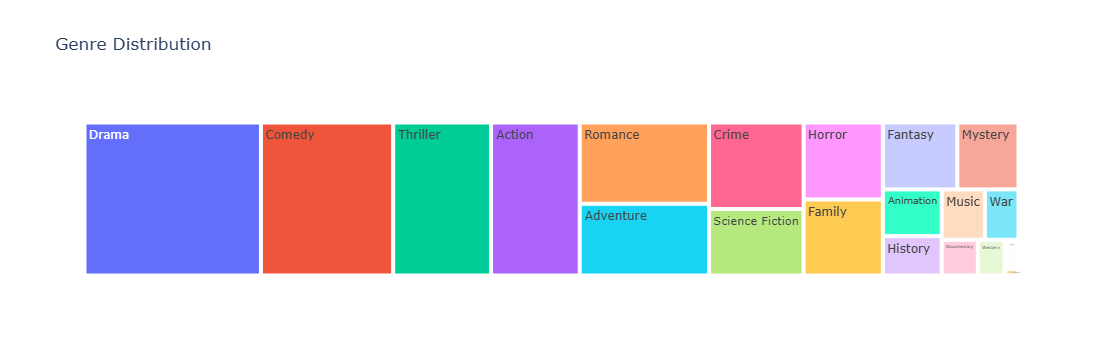

In [26]:
import plotly.express as px

count = genre_counts.reset_index()
count.columns = ['Category', 'Value']
fig = px.treemap(count, 
                  path=['Category'], 
                  values='Value', 
                  title='Genre Distribution')
fig.show()

## Testing

In [30]:
# user likes horror and mystery
user_genre_vector = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

movie_genre_vectors = genres_one_hot.values

# Compute similarity with each movie genre vector
similarity_scores = cosine_similarity([user_genre_vector], movie_genre_vectors)

# Sort movies by similarity score
recommended_movie_indices = similarity_scores[0].argsort()[::-1]

top_movies = df.iloc[recommended_movie_indices[:10], :]
top_movies

,id,title,genres
3601,24913,April Fool's Day,"[Horror, Mystery]"
1224,55779,Final Destination 5,"[Horror, Mystery]"
4080,92182,Silent House,"[Horror, Mystery]"
3189,293670,The Wailing,"[Horror, Mystery]"
2673,14435,My Bloody Valentine,"[Mystery, Horror]"
1219,41446,Scream 4,"[Horror, Mystery]"
1961,4233,Scream 2,"[Horror, Mystery]"
2928,22804,Saw VI,"[Horror, Mystery]"
1839,9286,Final Destination 3,"[Horror, Mystery]"
4577,23827,Paranormal Activity,"[Horror, Mystery]"


### Gradio App

In [31]:
import gradio as gr
import numpy as np

# List of all genres
genres = genres_one_hot.columns.tolist()
movie_genre_vectors = genres_one_hot.values

def generate_user_vector(selected_genres):
    # Initialize the genre vector with zeros (20 genres)
    genre_vector = [0] * len(genres)
    
    # Set the selected genres to 1
    for genre in selected_genres:
        genre_index = genres.index(genre) 
        genre_vector[genre_index] = 1
    
    return genre_vector

# Gradio Interface
def get_recommendations(selected_genres):
    user_genre_vector = generate_user_vector(selected_genres)
    # Compute similarity with each movie genre vector
    similarity_scores = cosine_similarity([user_genre_vector], movie_genre_vectors)

    # Sort movies by similarity score
    recommended_movie_indices = similarity_scores[0].argsort()[::-1]
    
    top_10_movies = df.iloc[recommended_movie_indices[:10], :]
    
    return top_10_movies

# Create the Gradio UI
demo = gr.Interface(
    fn=get_recommendations,
    inputs=gr.CheckboxGroup(choices=genres, label="Select your preferred genres"),
    outputs=gr.Dataframe(),
    title="Movie Genre Preferences",
    description="Select your favorite genres, and we'll recommend you some movies"
)

# Launch the Gradio app
demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
